<a href="https://colab.research.google.com/github/hsun26/CS445-Project/blob/main/Dual_CNN_(use_new_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torchsummary

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.4 MB/s eta 0:00:00


In [93]:
from torchsummary import summary
import os
import numpy as np
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [46]:
class HandGestureDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, transform=None):
        """
        Args:
            rgb_dir (string): Directory with all the RGB images divided into subdirectories.
            mask_dir (string): Directory with all the mask images divided into the same subdirectories as RGB images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        label_mapping = {'like': 0,'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}

        # Iterate over all categories
        for category in label_mapping:
            rgb_path = os.path.join(self.rgb_dir, category)
            mask_path = os.path.join(self.mask_dir, category)
            for filename in os.listdir(rgb_path):
                if filename.endswith('.jpg'):
                    # Constructing the mask filename based on the RGB filename
                    # RGB filename like '2_Original_046.jpg' corresponds to mask '2_Mask_046.jpg'
                    mask_filename = filename.replace('Original', 'Mask')   # so here I
                    file_rgb_path = os.path.join(rgb_path, filename)
                    file_mask_path = os.path.join(mask_path, mask_filename)
                    samples.append((file_rgb_path, file_mask_path, label_mapping[category]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, mask_path, label = self.samples[idx]
        rgb_image = Image.open(rgb_path).convert('RGB')
        mask_image = Image.open(mask_path).convert('L')  # Assuming masks are grayscale

        if self.transform:
            rgb_image = self.transform(rgb_image)
            mask_image = self.transform(mask_image)

        return rgb_image, mask_image, label

# Transformation to apply
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



In [47]:
dataset = HandGestureDataset('/content/drive/MyDrive/CS445/Final Project/rgb', '/content/drive/MyDrive/CS445/Final Project/generate', transform=transform)  #HandGestureDataset(hand_dir, mask_dir, transform=transform)
for i in range(5):  # Check first 5 samples
    print(dataset.samples[i])


('/content/drive/MyDrive/CS445/Final Project/rgb/like/like_Original_018.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/like/like_Mask_018.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/like/like_Original_022.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/like/like_Mask_022.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/like/like_Original_020.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/like/like_Mask_020.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/like/like_Original_016.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/like/like_Mask_016.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/like/like_Original_002.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/like/like_Mask_002.jpg', 0)


In [57]:
# # Split the dataset into training and testing
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # DataLoader setup
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

dataset_size = len(dataset)
indices = torch.randperm(dataset_size)  # Shuffle indices

# Calculate the size of the splits
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the indices into training and testing parts
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create subsets using the shuffled indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)  # Shuffling here may not be necessary since indices are already shuffled
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


### DC-CNN (pytorch)

In [59]:
class DualCNN(nn.Module):
    def __init__(self):
        super(DualCNN, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)  # calculated
        self.fc2 = nn.Linear(224, 6)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        # print("Output size after branch1:", out_img.shape)
        # print("Output size after branch2:", out_mask.shape)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        # print("Concatenated output size:", out.shape)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Initialize model
model = DualCNN().to(device)
print(model)


DualCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=125440, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=6, bias=True)
)


In [60]:
# model = DualCNN()
summary(model, [(3, 224, 224), (1, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 224, 224]           1,520
              ReLU-2         [-1, 20, 224, 224]               0
         MaxPool2d-3         [-1, 20, 112, 112]               0
            Conv2d-4         [-1, 20, 112, 112]          19,620
              ReLU-5         [-1, 20, 112, 112]               0
         MaxPool2d-6           [-1, 20, 56, 56]               0
            Conv2d-7         [-1, 20, 224, 224]             520
              ReLU-8         [-1, 20, 224, 224]               0
         MaxPool2d-9         [-1, 20, 112, 112]               0
           Conv2d-10         [-1, 20, 112, 112]          19,620
             ReLU-11         [-1, 20, 112, 112]               0
        MaxPool2d-12           [-1, 20, 56, 56]               0
           Linear-13                  [-1, 224]      28,098,784
           Linear-14                   

In [61]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the appropriate device (GPU or CPU)

    # Initialize lists to store metrics per epoch
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_precisions = []
    epoch_train_recalls = []
    epoch_train_f1s = []
    epoch_val_precisions = []
    epoch_val_recalls = []
    epoch_val_f1s = []

    for epoch in range(n_epochs):
        # Initialize metrics for the current epoch
        train_losses, val_losses = [], []
        train_preds, train_targets = [], []
        val_preds, val_targets = [], []

        # Training Phase
        model.train()
        train_tqdm = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for data_img, data_mask, labels in train_tqdm:
            data_img = data_img.to(device)
            data_mask = data_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(data_img, data_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            train_tqdm.set_postfix(loss=np.mean(train_losses))

        # Validation Phase
        model.eval()
        val_tqdm = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
        with torch.no_grad():
            for data_img, data_mask, labels in val_tqdm:
                data_img = data_img.to(device)
                data_mask = data_mask.to(device)
                labels = labels.to(device)

                outputs = model(data_img, data_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.detach().cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_tqdm.set_postfix(loss=np.mean(val_losses))

        # Calculate metrics for the current epoch
        train_precision = precision_score(train_targets, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_targets, train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(train_targets, train_preds, average='macro', zero_division=0)
        val_precision = precision_score(val_targets, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_targets, val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)

        # Store metrics for all epochs
        # epoch_train_losses.append(np.mean(train_losses))
        # epoch_val_losses.append(np.mean(val_losses))
        epoch_train_precisions.append(train_precision)
        epoch_train_recalls.append(train_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_precisions.append(val_precision)
        epoch_val_recalls.append(val_recall)
        epoch_val_f1s.append(val_f1)

        # End of Epoch Summary
        print(f'Epoch {epoch+1}: Training Loss: {np.mean(train_losses):.4f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'Validation Loss: {np.mean(val_losses):.4f}, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}')

    # Plotting the metrics
    epochs = range(1, n_epochs + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, epoch_train_precisions, 'r-', label='Train Precision')
    plt.plot(epochs, epoch_val_precisions, 'b-', label='Val Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, epoch_train_recalls, 'r-', label='Train Recall')
    plt.plot(epochs, epoch_val_recalls, 'b-', label='Val Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, epoch_train_f1s, 'r-', label='Train F1 Score')
    plt.plot(epochs, epoch_val_f1s, 'b-', label='Val F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [62]:
model = DualCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s, loss=1.78]


Epoch 1: Training Loss: 1.7908, Precision: 0.07, Recall: 0.15, F1: 0.09
Validation Loss: 1.7823, Precision: 0.27, Recall: 0.22, F1: 0.13


Validation Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s, loss=1.67]


Epoch 2: Training Loss: 1.7381, Precision: 0.24, Recall: 0.29, F1: 0.24
Validation Loss: 1.6662, Precision: 0.19, Recall: 0.33, F1: 0.24


Validation Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s, loss=1.52]


Epoch 3: Training Loss: 1.5727, Precision: 0.35, Recall: 0.36, F1: 0.35
Validation Loss: 1.5173, Precision: 0.27, Recall: 0.39, F1: 0.30


Validation Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, loss=1.52]


Epoch 4: Training Loss: 1.5263, Precision: 0.36, Recall: 0.37, F1: 0.36
Validation Loss: 1.5213, Precision: 0.44, Recall: 0.37, F1: 0.28


Validation Epoch 5: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s, loss=1.37]


Epoch 5: Training Loss: 1.4164, Precision: 0.43, Recall: 0.43, F1: 0.42
Validation Loss: 1.3682, Precision: 0.52, Recall: 0.48, F1: 0.47


Validation Epoch 6: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it, loss=1.4]


Epoch 6: Training Loss: 1.3590, Precision: 0.46, Recall: 0.46, F1: 0.46
Validation Loss: 1.3970, Precision: 0.47, Recall: 0.48, F1: 0.43


Validation Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s, loss=1.37]


Epoch 7: Training Loss: 1.2610, Precision: 0.51, Recall: 0.51, F1: 0.51
Validation Loss: 1.3744, Precision: 0.42, Recall: 0.45, F1: 0.40


Validation Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s, loss=1.54]


Epoch 8: Training Loss: 1.1981, Precision: 0.55, Recall: 0.55, F1: 0.55
Validation Loss: 1.5396, Precision: 0.49, Recall: 0.44, F1: 0.36


Validation Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s, loss=1.38]


Epoch 9: Training Loss: 1.0835, Precision: 0.61, Recall: 0.61, F1: 0.61
Validation Loss: 1.3849, Precision: 0.44, Recall: 0.45, F1: 0.41


Validation Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, loss=1.3]


Epoch 10: Training Loss: 0.9718, Precision: 0.62, Recall: 0.63, F1: 0.62
Validation Loss: 1.3025, Precision: 0.54, Recall: 0.53, F1: 0.50


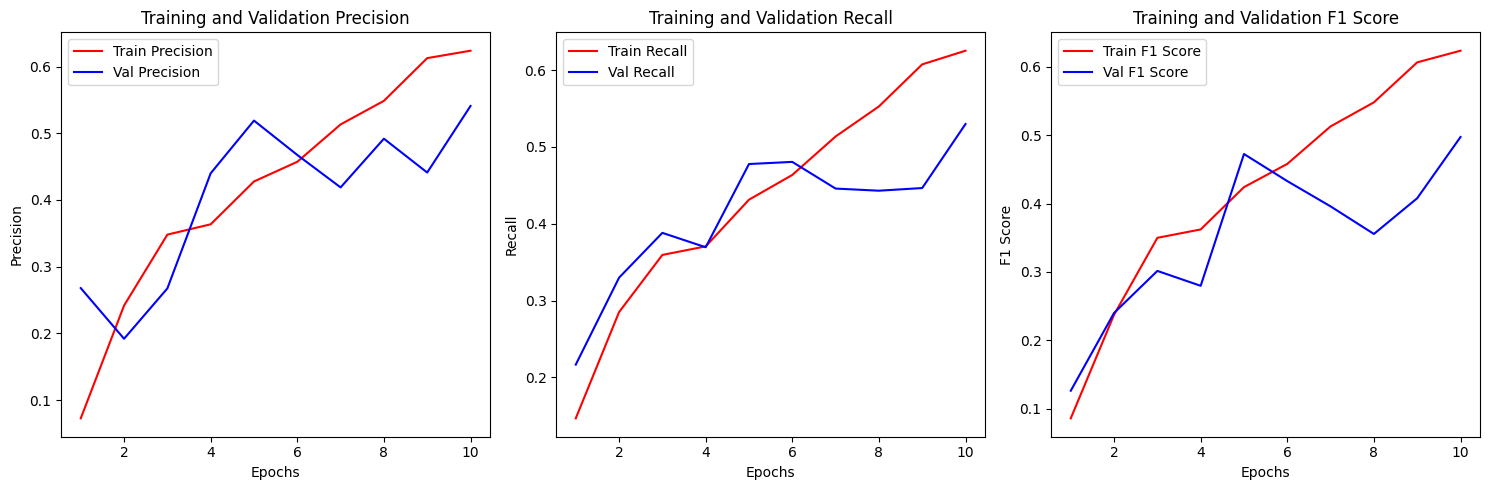

In [63]:
train_and_validate(model, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [64]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_CNN_model.pth'
torch.save(model.state_dict(), model_path)

Test

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def load_image(image_path, mask_path=None, image_size=224):
    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # Normalize with the same parameters used in training

    ])

    # Load image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)

    # If a mask is required
    if mask_path:
        mask = Image.open(mask_path).convert('L')
        mask = transform(mask)
    else:
        mask = None

    return image, mask

def test_model(model, image_path, mask_path=None):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image, mask = load_image(image_path, mask_path)
        if mask is not None:
            image, mask = image.unsqueeze(0), mask.unsqueeze(0)  # Add batch dimension
            outputs = model(image, mask)
        else:
            image = image.unsqueeze(0)  # Add batch dimension
            outputs = model(image)

        # the output is class scores
        _, predicted = torch.max(outputs, 1)
        return predicted.item()


model = DualCNN()

predicted_class = test_model(model, '/content/drive/MyDrive/CS445/Final Project/1_A_hgr2A1_id02_1.jpg', '/content/drive/MyDrive/CS445/Final Project/1_A_hgr2A1_id02_1.bmp')
print("Predicted Class:", predicted_class)


Predicted Class: 0


In [ ]:
predicted_class = test_model(model, 'path_to_test_image.jpg', 'path_to_test_mask.bmp')
print("Predicted Class:", predicted_class)

### DCCNN (use different regularization)

In [69]:
class DualCNN(nn.Module):
    def __init__(self):
        super(DualCNN, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)  # Dropout added after pooling
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)  # Dropout added after pooling
        )

        # Fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)
        self.fc2 = nn.Dropout(0.5)  # Dropout before the final classification layer
        self.fc3 = nn.Linear(224, 6)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)  # Applying dropout
        out = self.fc3(out)  # Final output layer
        return out

# Initialize model
model_2 = DualCNN().to(device)
print(model_2)


DualCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=125440, out_features=224, bias=True)
  (fc2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=224, out_features=6, bias

In [71]:
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9, weight_decay = 1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, loss=1.78]


Epoch 1: Training Loss: 1.7932, Precision: 0.16, Recall: 0.16, F1: 0.15
Validation Loss: 1.7848, Precision: 0.34, Recall: 0.30, F1: 0.18


Validation Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s, loss=1.74]


Epoch 2: Training Loss: 1.7695, Precision: 0.25, Recall: 0.24, F1: 0.20
Validation Loss: 1.7415, Precision: 0.13, Recall: 0.23, F1: 0.13


Validation Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=1.63]


Epoch 3: Training Loss: 1.7012, Precision: 0.24, Recall: 0.25, F1: 0.24
Validation Loss: 1.6259, Precision: 0.33, Recall: 0.42, F1: 0.36


Validation Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, loss=1.59]


Epoch 4: Training Loss: 1.6289, Precision: 0.29, Recall: 0.30, F1: 0.29
Validation Loss: 1.5889, Precision: 0.26, Recall: 0.38, F1: 0.29


Validation Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=1.53]


Epoch 5: Training Loss: 1.6056, Precision: 0.33, Recall: 0.33, F1: 0.33
Validation Loss: 1.5274, Precision: 0.36, Recall: 0.38, F1: 0.32


Validation Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, loss=1.44]


Epoch 6: Training Loss: 1.5310, Precision: 0.36, Recall: 0.37, F1: 0.36
Validation Loss: 1.4438, Precision: 0.46, Recall: 0.43, F1: 0.39


Validation Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s, loss=1.38]


Epoch 7: Training Loss: 1.4863, Precision: 0.39, Recall: 0.40, F1: 0.39
Validation Loss: 1.3834, Precision: 0.42, Recall: 0.49, F1: 0.43


Validation Epoch 8: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s, loss=1.37]


Epoch 8: Training Loss: 1.4591, Precision: 0.38, Recall: 0.39, F1: 0.38
Validation Loss: 1.3741, Precision: 0.34, Recall: 0.44, F1: 0.35


Validation Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, loss=1.46]


Epoch 9: Training Loss: 1.4028, Precision: 0.38, Recall: 0.38, F1: 0.38
Validation Loss: 1.4603, Precision: 0.35, Recall: 0.44, F1: 0.36


Validation Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, loss=1.36]


Epoch 10: Training Loss: 1.3259, Precision: 0.48, Recall: 0.49, F1: 0.48
Validation Loss: 1.3628, Precision: 0.42, Recall: 0.43, F1: 0.38


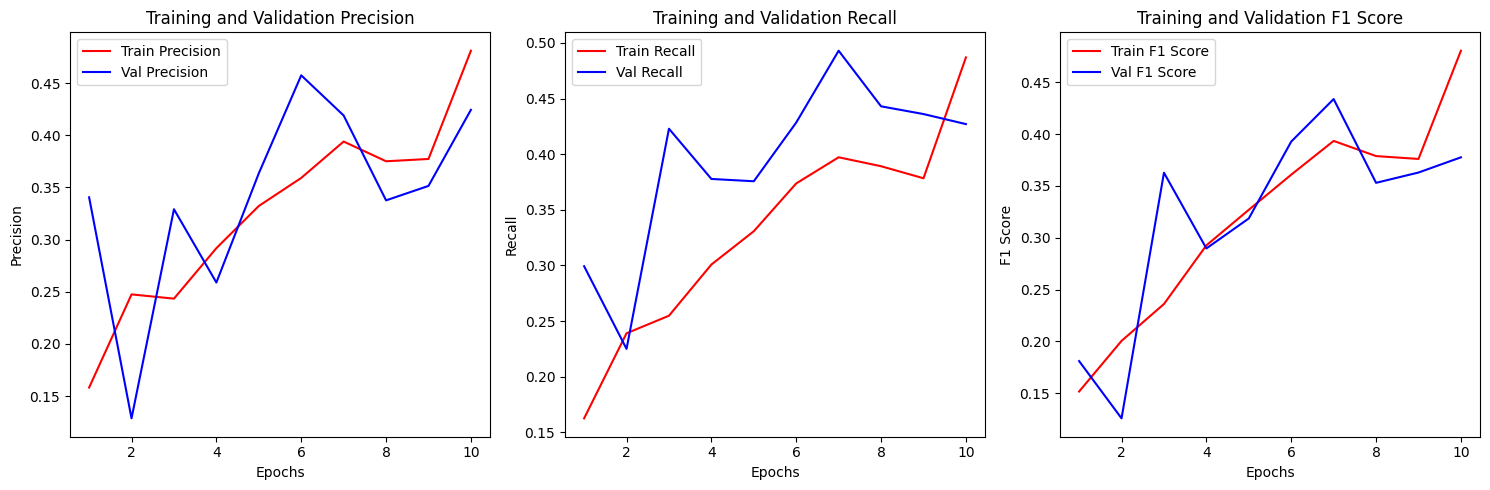

In [72]:
# 原始设置  dropout =0.5
train_and_validate(model_2, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [77]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_CNN_model_dropout.pth'
torch.save(model_2.state_dict(), model_path)

batchnorm + dropout

In [73]:
class DualCNN(nn.Module):
    def __init__(self):
        super(DualCNN, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.BatchNorm2d(20),  # Batch Normalization after convolution
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),  # Dropout after pooling

            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.BatchNorm2d(20),  # Batch Normalization after convolution
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)  # Dropout after pooling
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.BatchNorm2d(20),  # Batch Normalization after convolution
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),  # Dropout after pooling

            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.BatchNorm2d(20),  # Batch Normalization after convolution
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)  # Dropout after pooling
        )

        # Fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)
        self.fc2 = nn.Dropout(0.5)  # Dropout before the final classification layer
        self.fc3 = nn.Linear(224, 6)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)  # Applying dropout
        out = self.fc3(out)  # Final output layer
        return out


model_3 = DualCNN().to(device)
print(model_3)


DualCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (6): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(20, 20, ker

In [75]:
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9, weight_decay = 1e-04) # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s, loss=1.75]


Epoch 1: Training Loss: 2.2137, Precision: 0.18, Recall: 0.17, F1: 0.17
Validation Loss: 1.7522, Precision: 0.08, Recall: 0.18, F1: 0.10


Validation Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s, loss=1.74]


Epoch 2: Training Loss: 1.7610, Precision: 0.23, Recall: 0.21, F1: 0.15
Validation Loss: 1.7385, Precision: 0.12, Recall: 0.24, F1: 0.15


Validation Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=1.72]


Epoch 3: Training Loss: 1.7524, Precision: 0.24, Recall: 0.21, F1: 0.20
Validation Loss: 1.7249, Precision: 0.21, Recall: 0.31, F1: 0.23


Validation Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=1.66]


Epoch 4: Training Loss: 1.7262, Precision: 0.18, Recall: 0.24, F1: 0.19
Validation Loss: 1.6573, Precision: 0.39, Recall: 0.35, F1: 0.26


Validation Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s, loss=1.62]


Epoch 5: Training Loss: 1.7288, Precision: 0.31, Recall: 0.21, F1: 0.18
Validation Loss: 1.6219, Precision: 0.21, Recall: 0.36, F1: 0.24


Validation Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=1.63]


Epoch 6: Training Loss: 1.7113, Precision: 0.22, Recall: 0.23, F1: 0.21
Validation Loss: 1.6274, Precision: 0.18, Recall: 0.26, F1: 0.17


Validation Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s, loss=1.67]


Epoch 7: Training Loss: 1.7612, Precision: 0.17, Recall: 0.19, F1: 0.13
Validation Loss: 1.6710, Precision: 0.21, Recall: 0.21, F1: 0.15


Validation Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s, loss=1.64]


Epoch 8: Training Loss: 1.7497, Precision: 0.23, Recall: 0.19, F1: 0.14
Validation Loss: 1.6401, Precision: 0.14, Recall: 0.26, F1: 0.17


Validation Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s, loss=1.68]


Epoch 9: Training Loss: 1.7156, Precision: 0.20, Recall: 0.21, F1: 0.16
Validation Loss: 1.6775, Precision: 0.29, Recall: 0.23, F1: 0.19


Validation Epoch 10: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s, loss=1.58]


Epoch 10: Training Loss: 1.7017, Precision: 0.25, Recall: 0.22, F1: 0.19
Validation Loss: 1.5803, Precision: 0.16, Recall: 0.30, F1: 0.20


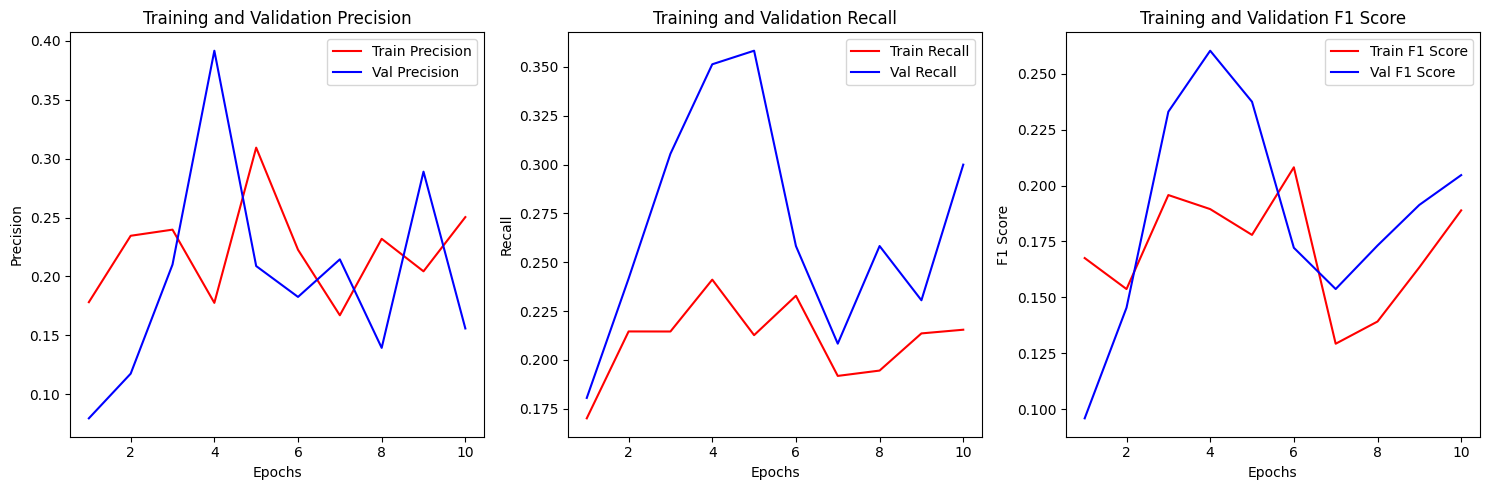

In [76]:
# 原始设置  lr=0.001, momentum=0.9
train_and_validate(model_3, criterion, optimizer, train_loader, test_loader, n_epochs=10)

### Use Data augmentation

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, transform=None):
        """
        Args:
            rgb_dir (string): Directory with all the RGB images divided into subdirectories.
            mask_dir (string): Directory with all the mask images divided into the same subdirectories as RGB images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.rgb_transform = rgb_transform
        self.mask_transform = mask_transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        label_mapping = {'one': 0, 'two': 1, 'three': 2, 'four': 3, 'five': 4, 'like': 5, 'ok': 6}

        # Iterate over all categories (e.g., 'one', 'two', etc.)
        for category in label_mapping:
            rgb_path = os.path.join(self.rgb_dir, category)
            mask_path = os.path.join(self.mask_dir, category)
            for filename in os.listdir(rgb_path):
                if filename.endswith('.jpg'):
                    # Constructing the mask filename based on the RGB filename
                    # RGB filename like '2_Original_046.jpg' corresponds to mask '2_Mask_046.jpg'
                    mask_filename = filename.replace('Original', 'Mask')
                    file_rgb_path = os.path.join(rgb_path, filename)
                    file_mask_path = os.path.join(mask_path, mask_filename)
                    samples.append((file_rgb_path, file_mask_path, label_mapping[category]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, mask_path, label = self.samples[idx]
        rgb_image = Image.open(rgb_path).convert('RGB')
        mask_image = Image.open(mask_path).convert('L')  # 确保掩码是单通道的

        if self.rgb_transform:
            rgb_image = self.rgb_transform(rgb_image)
        if self.mask_transform:
            mask_image = self.mask_transform(mask_image)

        return rgb_image, mask_image, label

# Transformation to apply
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize all images to the same size for model consistency
#     transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
#     transforms.RandomRotation(15),  # Randomly rotate images by up to 15 degrees
#     transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Randomly jitter brightness and contrast
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize tensors
# ])


rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 保持大小一致
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(15),  # 随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 调整亮度和对比度
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # 掩码也需要翻转以匹配图像的变换
    transforms.RandomRotation(15),  # 掩码也需要旋转
    transforms.ToTensor()  # 直接转为张量，不需要归一化
])

In [ ]:
dataset = HandGestureDataset('/content/drive/MyDrive/CS445/Final Project/rgb', '/content/drive/MyDrive/CS445/Final Project/generate', transform=transform)
for i in range(5):  # Check first 5 samples
    print(dataset.samples[i])


('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_018.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_018.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_022.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_022.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_010.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_010.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_021.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_021.jpg', 0)
('/content/drive/MyDrive/CS445/Final Project/rgb/one/1_Original_024.jpg', '/content/drive/MyDrive/CS445/Final Project/generate/one/1_Mask_024.jpg', 0)


In [ ]:
# hand_dir = '/content/drive/MyDrive/CS445/Final Project/rgb'
# mask_dir = '/content/drive/MyDrive/CS445/Final Project/generate'
# dataset = HandGestureDataset(hand_dir, mask_dir, transform=transform)

# Split the dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [ ]:
class DualCNN(nn.Module):
    def __init__(self):
        super(DualCNN, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)  # calculated
        self.fc2 = nn.Linear(224, 7)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        # print("Output size after branch1:", out_img.shape)  # Debug: Check output size
        # print("Output size after branch2:", out_mask.shape)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        # print("Concatenated output size:", out.shape)  # Debug: Check concatenated size

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Initialize model
model = DualCNN()
print(model)


DualCNN(
  (branch1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=125440, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=7, bias=True)
)


In [ ]:

def train_and_validate(model, criterion, optimizer, train_loader, val_loader, n_epochs=10):
    for epoch in range(n_epochs):
        # Initialize metrics
        train_losses, val_losses = [], []
        train_preds, train_targets = [], []
        val_preds, val_targets = [], []

        # Training Phase
        model.train()
        train_tqdm = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for data_img, data_mask, labels in train_tqdm:
            optimizer.zero_grad()
            outputs = model(data_img, data_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss and predictions
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

            # Update progress bar
            train_tqdm.set_postfix(loss=np.mean(train_losses))

        # Validation Phase
        model.eval()
        val_tqdm = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
        with torch.no_grad():
            for data_img, data_mask, labels in val_tqdm:
                outputs = model(data_img, data_mask)
                loss = criterion(outputs, labels)

                # Accumulate loss and predictions
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

                # Update progress bar
                val_tqdm.set_postfix(loss=np.mean(val_losses))

        # Calculate metrics for training
        train_precision = precision_score(train_targets, train_preds, average='macro')
        train_recall = recall_score(train_targets, train_preds, average='macro')
        train_f1 = f1_score(train_targets, train_preds, average='macro')

        # Calculate metrics for validation
        val_precision = precision_score(val_targets, val_preds, average='macro')
        val_recall = recall_score(val_targets, val_preds, average='macro')
        val_f1 = f1_score(val_targets, val_preds, average='macro')

        # End of Epoch Summary
        print(f'Epoch {epoch+1}: Training Loss: {np.mean(train_losses):.4f}')
        print(f'Training Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'Validation Loss: {np.mean(val_losses):.4f}')
        print(f'Validation Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}')


In [ ]:
model = DualCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

In [ ]:
# 原始设置
train_and_validate(model, criterion, optimizer, train_loader, test_loader, n_epochs=10)

Validation Epoch 1: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it, loss=1.84]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Training Loss: 1.8749
Training Precision: 0.13, Recall: 0.15, F1: 0.13
Validation Loss: 1.8356
Validation Precision: 0.09, Recall: 0.18, F1: 0.12


Validation Epoch 2: 100%|██████████| 6/6 [00:16<00:00,  2.77s/it, loss=1.87]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Training Loss: 1.8159
Training Precision: 0.11, Recall: 0.18, F1: 0.13
Validation Loss: 1.8692
Validation Precision: 0.04, Recall: 0.13, F1: 0.06


Validation Epoch 3: 100%|██████████| 6/6 [00:14<00:00,  2.48s/it, loss=1.76]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Training Loss: 1.7855
Training Precision: 0.26, Recall: 0.19, F1: 0.16
Validation Loss: 1.7585
Validation Precision: 0.32, Recall: 0.27, F1: 0.23


Validation Epoch 4: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it, loss=1.69]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Training Loss: 1.7683
Training Precision: 0.25, Recall: 0.21, F1: 0.20
Validation Loss: 1.6888
Validation Precision: 0.33, Recall: 0.31, F1: 0.25


Validation Epoch 5: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it, loss=1.49]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Training Loss: 1.6606
Training Precision: 0.44, Recall: 0.31, F1: 0.28
Validation Loss: 1.4938
Validation Precision: 0.16, Recall: 0.28, F1: 0.18


Validation Epoch 6: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it, loss=1.51]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Training Loss: 1.5826
Training Precision: 0.29, Recall: 0.27, F1: 0.25
Validation Loss: 1.5051
Validation Precision: 0.36, Recall: 0.33, F1: 0.31


Validation Epoch 7: 100%|██████████| 6/6 [00:13<00:00,  2.32s/it, loss=1.57]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Training Loss: 1.6080
Training Precision: 0.40, Recall: 0.35, F1: 0.36
Validation Loss: 1.5667
Validation Precision: 0.15, Recall: 0.35, F1: 0.21


Validation Epoch 8: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it, loss=1.72]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Training Loss: 1.5689
Training Precision: 0.45, Recall: 0.29, F1: 0.27
Validation Loss: 1.7211
Validation Precision: 0.45, Recall: 0.34, F1: 0.33


Validation Epoch 9: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it, loss=1.36]


Epoch 9: Training Loss: 1.4419
Training Precision: 0.43, Recall: 0.36, F1: 0.37
Validation Loss: 1.3568
Validation Precision: 0.48, Recall: 0.34, F1: 0.28


Validation Epoch 10: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it, loss=1.47]

Epoch 10: Training Loss: 1.3852
Training Precision: 0.49, Recall: 0.44, F1: 0.45
Validation Loss: 1.4690
Validation Precision: 0.29, Recall: 0.40, F1: 0.30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Hyperparameter tuning （没整）

In [ ]:
class DualCNN(nn.Module):
    def __init__(self, num_filters=20, kernel_size1=5, kernel_size2=7, padding1=2, padding2=3):
        super(DualCNN, self).__init__()
        # First branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=kernel_size1, padding=padding1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size2, padding=padding2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel_size1, padding=padding1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel_size2, padding=padding2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(num_filters * 56 * 56 * 2, 224)  # Adjust size calculation as necessary
        self.fc2 = nn.Linear(224, 7)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [ ]:
import optuna
import torch.optim as optim

def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    num_filters = trial.suggest_categorical("num_filters", [16, 32, 64])
    kernel_size1 = trial.suggest_categorical("kernel_size1", [3, 5, 7])

    model = DualCNN(num_filters=num_filters, kernel_size1=kernel_size1)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):  # Reduced number of epochs for quick tuning
        model.train()
        for data_img, data_mask, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data_img, data_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        accuracy = evaluate(model, val_loader)  # Define a function to calculate validation accuracy

    return accuracy  # Objective value to maximize

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_trial.params)


[I 2024-05-03 20:32:36,911] A new study created in memory with name: no-name-af2aee04-8f52-43d3-8139-44a75cd0bb36
[W 2024-05-03 20:33:17,104] Trial 0 failed with parameters: {'lr': 0.00039582641463206545, 'num_filters': 16, 'kernel_size1': 5} because of the following error: NameError("name 'evaluate' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-36-58233ae8c4dd>", line 25, in objective
    accuracy = evaluate(model, val_loader)  # Define a function to calculate validation accuracy
NameError: name 'evaluate' is not defined
[W 2024-05-03 20:33:17,106] Trial 0 failed with value None.


NameError: name 'evaluate' is not defined

### DC CNN + ATTENTION

In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DualCNN_attention(nn.Module):
    def __init__(self):
        super(DualCNN_attention, self).__init__()
        # Define the first branch for the RGB image
        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),  # Padding=2 to keep size constant
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),  # Larger kernel and padding
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define the second branch for the mask image
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Attention Gate
        self.attention_gate = AttentionGate(F_g=20, F_l=20, F_int=10)

        # Define the fully connected layers
        self.fc1 = nn.Linear(20 * 56 * 56 * 2, 224)  # calculated
        self.fc2 = nn.Linear(224, 6)

    def forward(self, x_img, x_mask):
        out_img = self.branch1(x_img)
        out_mask = self.branch2(x_mask)

        # Apply attention
        out_mask = self.attention_gate(out_img, out_mask)

        out_img = out_img.view(out_img.size(0), -1)
        out_mask = out_mask.view(out_mask.size(0), -1)
        out = torch.cat((out_img, out_mask), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [ ]:
model_att = DualCNN_attention()
optimizer = torch.optim.SGD(model_att.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

In [ ]:
train_and_validate(model_att, criterion, optimizer, train_loader, test_loader, n_epochs=10)

Validation Epoch 1: 100%|██████████| 6/6 [00:20<00:00,  3.40s/it, loss=1.87]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Training Loss: 1.8974
Training Precision: 0.12, Recall: 0.15, F1: 0.12
Validation Loss: 1.8740
Validation Precision: 0.03, Recall: 0.14, F1: 0.05


Validation Epoch 2: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it, loss=1.57]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Training Loss: 1.7784
Training Precision: 0.31, Recall: 0.22, F1: 0.20
Validation Loss: 1.5694
Validation Precision: 0.37, Recall: 0.29, F1: 0.25


Validation Epoch 3: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it, loss=1.74]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Training Loss: 1.6263
Training Precision: 0.38, Recall: 0.37, F1: 0.37
Validation Loss: 1.7401
Validation Precision: 0.22, Recall: 0.19, F1: 0.15


Validation Epoch 4: 100%|██████████| 6/6 [00:16<00:00,  2.77s/it, loss=1.57]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Training Loss: 1.5110
Training Precision: 0.37, Recall: 0.37, F1: 0.36
Validation Loss: 1.5689
Validation Precision: 0.41, Recall: 0.29, F1: 0.31


Validation Epoch 5: 100%|██████████| 6/6 [00:16<00:00,  2.72s/it, loss=1.6]


Epoch 5: Training Loss: 1.4430
Training Precision: 0.49, Recall: 0.44, F1: 0.46
Validation Loss: 1.5979
Validation Precision: 0.37, Recall: 0.31, F1: 0.29


Validation Epoch 6: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it, loss=2.25]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Training Loss: 1.2640
Training Precision: 0.59, Recall: 0.52, F1: 0.54
Validation Loss: 2.2527
Validation Precision: 0.26, Recall: 0.35, F1: 0.27


Validation Epoch 7: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it, loss=2.11]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Training Loss: 1.3042
Training Precision: 0.53, Recall: 0.51, F1: 0.51
Validation Loss: 2.1095
Validation Precision: 0.18, Recall: 0.34, F1: 0.22


Validation Epoch 8: 100%|██████████| 6/6 [00:16<00:00,  2.77s/it, loss=2.03]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Training Loss: 1.1100
Training Precision: 0.63, Recall: 0.55, F1: 0.57
Validation Loss: 2.0338
Validation Precision: 0.22, Recall: 0.36, F1: 0.26


Validation Epoch 9: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it, loss=1.79]


Epoch 9: Training Loss: 1.0383
Training Precision: 0.64, Recall: 0.57, F1: 0.59
Validation Loss: 1.7899
Validation Precision: 0.33, Recall: 0.36, F1: 0.32


Validation Epoch 10: 100%|██████████| 6/6 [00:16<00:00,  2.79s/it, loss=2.07]

Epoch 10: Training Loss: 0.6715
Training Precision: 0.76, Recall: 0.75, F1: 0.75
Validation Loss: 2.0661
Validation Precision: 0.35, Recall: 0.43, F1: 0.32


### DC + ResNet18 (LIGHTWEIGHT)

In [80]:
class DualResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(DualResNet, self).__init__()

        # Initialize ResNet backbones
        self.resnet_branch1 = models.resnet18(pretrained=True)  # pre-trained on imagenet
        self.resnet_branch1.fc = nn.Identity()

        self.resnet_branch2 = models.resnet18(pretrained=True)
        self.resnet_branch2.fc = nn.Identity()

        # Modify the first convolution layer of the second branch to accept 1-channel input
        self.resnet_branch2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2, 224)  # the output of each ResNet is 512 features
        self.fc2 = nn.Linear(224, num_classes)

    def forward(self, x_img, x_mask):
        # Process inputs through each ResNet branch
        out_img = self.resnet_branch1(x_img)
        out_mask = self.resnet_branch2(x_mask)

        # Concatenate features from both branches
        out = torch.cat((out_img, out_mask), dim=1)

        # Pass through fully connected layers
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Initialize and print model
model_res = DualResNet()
print(model_res)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


DualResNet(
  (resnet_branch1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [81]:
model_res = DualResNet()
optimizer = torch.optim.SGD(model_res.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

Validation Epoch 1: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, loss=1.68]


Epoch 1: Training Loss: 1.7237, Precision: 0.30, Recall: 0.27, F1: 0.27
Validation Loss: 1.6777, Precision: 0.30, Recall: 0.39, F1: 0.32


Validation Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s, loss=1.17]


Epoch 2: Training Loss: 1.3286, Precision: 0.57, Recall: 0.57, F1: 0.56
Validation Loss: 1.1745, Precision: 0.57, Recall: 0.53, F1: 0.45


Validation Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s, loss=0.923]


Epoch 3: Training Loss: 0.9116, Precision: 0.72, Recall: 0.72, F1: 0.71
Validation Loss: 0.9228, Precision: 0.69, Recall: 0.66, F1: 0.65


Validation Epoch 4: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s, loss=0.709]


Epoch 4: Training Loss: 0.6887, Precision: 0.77, Recall: 0.78, F1: 0.77
Validation Loss: 0.7087, Precision: 0.76, Recall: 0.70, F1: 0.67


Validation Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s, loss=0.679]


Epoch 5: Training Loss: 0.4449, Precision: 0.87, Recall: 0.86, F1: 0.86
Validation Loss: 0.6791, Precision: 0.81, Recall: 0.80, F1: 0.79


Validation Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, loss=0.667]


Epoch 6: Training Loss: 0.2956, Precision: 0.94, Recall: 0.94, F1: 0.94
Validation Loss: 0.6670, Precision: 0.78, Recall: 0.71, F1: 0.70


Validation Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s, loss=0.62]


Epoch 7: Training Loss: 0.1945, Precision: 0.95, Recall: 0.95, F1: 0.95
Validation Loss: 0.6200, Precision: 0.77, Recall: 0.78, F1: 0.75


Validation Epoch 8: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, loss=0.554]


Epoch 8: Training Loss: 0.1160, Precision: 0.98, Recall: 0.98, F1: 0.98
Validation Loss: 0.5541, Precision: 0.79, Recall: 0.78, F1: 0.76


Validation Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s, loss=0.693]


Epoch 9: Training Loss: 0.0963, Precision: 0.98, Recall: 0.98, F1: 0.98
Validation Loss: 0.6927, Precision: 0.80, Recall: 0.79, F1: 0.76


Validation Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s, loss=0.6]


Epoch 10: Training Loss: 0.0714, Precision: 0.99, Recall: 0.99, F1: 0.99
Validation Loss: 0.5998, Precision: 0.82, Recall: 0.80, F1: 0.79


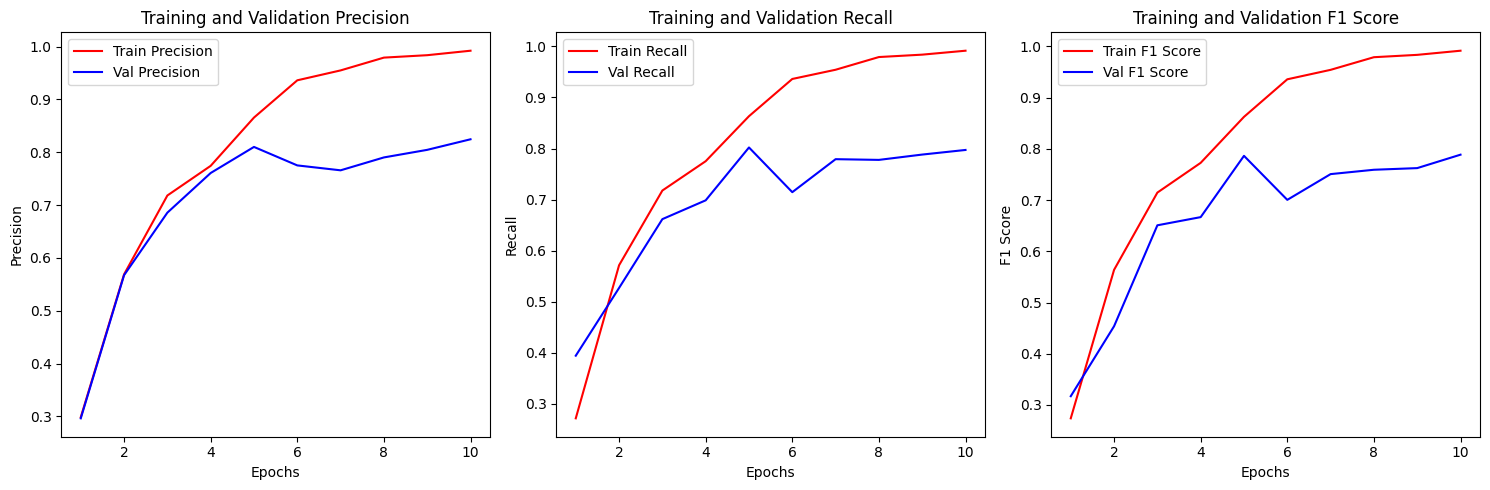

In [82]:
train_and_validate(model_res, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [83]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_ResNet_model.pth'
torch.save(model_res.state_dict(), model_path)

### DC + VGG 19

In [84]:
class DualVGG(nn.Module):
    def __init__(self, num_classes=6):
        super(DualVGG, self).__init__()

        # Load pre-trained VGG16 for the first branch (handling RGB images)
        base_model1 = models.vgg16(pretrained=True)
        # Correctly handling the avgpool
        self.vgg_branch1 = nn.Sequential(
            *base_model1.features,
            base_model1.avgpool,
            nn.Flatten()
        )

        # Load pre-trained VGG16 for the second branch (handling mask images)
        base_model2 = models.vgg16(pretrained=True)
        # Modify the first convolutional layer to accept 1-channel input
        base_model2.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        # Correctly handling the avgpool
        self.vgg_branch2 = nn.Sequential(
            *base_model2.features,
            base_model2.avgpool,
            nn.Flatten()
        )

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7 * 2, 4096),  # Adjust based on the output size from the avgpool layer
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # Outputs for 7 classes
        )

    def forward(self, x_img, x_mask):
        # Process inputs through each VGG branch
        x_img = self.vgg_branch1(x_img)
        x_mask = self.vgg_branch2(x_mask)

        # Concatenate features from both branches
        x = torch.cat((x_img, x_mask), dim=1)

        # Classification
        x = self.classifier(x)
        return x

In [86]:
model_vgg = DualVGG(num_classes=6)
print(model_vgg)
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DualVGG(
  (vgg_branch1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

Validation Epoch 1: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s, loss=1.49]


Epoch 1: Training Loss: 1.7379, Precision: 0.26, Recall: 0.22, F1: 0.20
Validation Loss: 1.4942, Precision: 0.51, Recall: 0.49, F1: 0.43


Validation Epoch 2: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s, loss=0.895]


Epoch 2: Training Loss: 1.2377, Precision: 0.51, Recall: 0.51, F1: 0.51
Validation Loss: 0.8953, Precision: 0.61, Recall: 0.63, F1: 0.60


Validation Epoch 3: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.528]


Epoch 3: Training Loss: 0.7726, Precision: 0.70, Recall: 0.69, F1: 0.69
Validation Loss: 0.5283, Precision: 0.79, Recall: 0.78, F1: 0.77


Validation Epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.889]


Epoch 4: Training Loss: 0.4790, Precision: 0.83, Recall: 0.83, F1: 0.83
Validation Loss: 0.8890, Precision: 0.77, Recall: 0.68, F1: 0.65


Validation Epoch 5: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, loss=0.542]


Epoch 5: Training Loss: 0.2572, Precision: 0.92, Recall: 0.92, F1: 0.92
Validation Loss: 0.5417, Precision: 0.81, Recall: 0.81, F1: 0.79


Validation Epoch 6: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.427]


Epoch 6: Training Loss: 0.2457, Precision: 0.90, Recall: 0.90, F1: 0.90
Validation Loss: 0.4274, Precision: 0.85, Recall: 0.85, F1: 0.84


Validation Epoch 7: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s, loss=0.647]


Epoch 7: Training Loss: 0.1098, Precision: 0.97, Recall: 0.96, F1: 0.96
Validation Loss: 0.6466, Precision: 0.82, Recall: 0.83, F1: 0.82


Validation Epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.582]


Epoch 8: Training Loss: 0.1157, Precision: 0.97, Recall: 0.97, F1: 0.97
Validation Loss: 0.5819, Precision: 0.83, Recall: 0.77, F1: 0.78


Validation Epoch 9: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, loss=0.585]


Epoch 9: Training Loss: 0.1556, Precision: 0.95, Recall: 0.95, F1: 0.95
Validation Loss: 0.5854, Precision: 0.84, Recall: 0.85, F1: 0.84


Validation Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, loss=0.411]


Epoch 10: Training Loss: 0.1399, Precision: 0.97, Recall: 0.96, F1: 0.96
Validation Loss: 0.4113, Precision: 0.87, Recall: 0.87, F1: 0.86


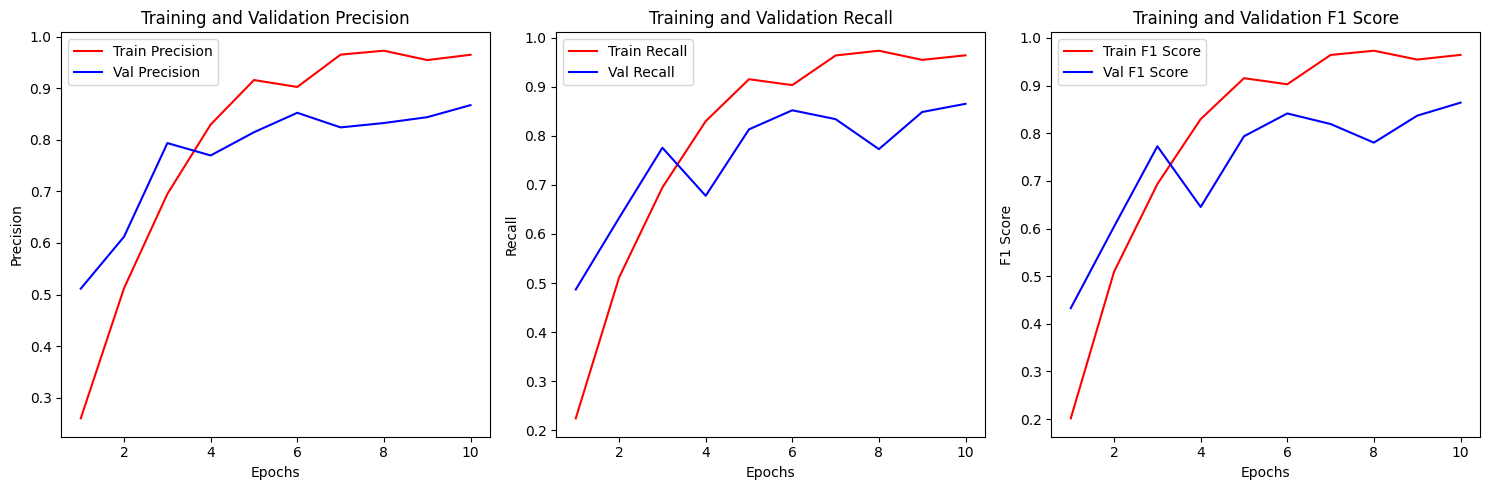

In [87]:
train_and_validate(model_vgg, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [88]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_VGG_model.pth'
torch.save(model_vgg.state_dict(), model_path)

### DC+ DenseNet

In [89]:
class DualDenseNet(nn.Module):
    def __init__(self, num_classes=6):
        super(DualDenseNet, self).__init__()

        # Load pre-trained DenseNet121 for the first branch (RGB images)
        base_model1 = models.densenet121(pretrained=True)
        self.dense_branch1 = nn.Sequential(*list(base_model1.features), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

        # Load pre-trained DenseNet121 for the second branch (mask images)
        base_model2 = models.densenet121(pretrained=True)
        # Modify the first convolutional layer to accept 1-channel input
        base_model2.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.dense_branch2 = nn.Sequential(*list(base_model2.features), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 2, 512),  # DenseNet121 outputs 1024 features, concatenated from both branches
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x_img, x_mask):
        # Process inputs through each DenseNet branch
        x_img = self.dense_branch1(x_img)
        x_mask = self.dense_branch2(x_mask)

        # Concatenate features from both branches
        x = torch.cat((x_img, x_mask), dim=1)

        # Classification
        x = self.classifier(x)
        return x


In [90]:
model_dense = DualDenseNet(num_classes=6)
print(model_dense)
optimizer = torch.optim.SGD(model_dense .parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)   # update the model's parameters (weights and biases) during the training
criterion = nn.CrossEntropyLoss()  #define loss function

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 83.0MB/s]


DualDenseNet(
  (dense_branch1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=

Validation Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, loss=1.71]


Epoch 1: Training Loss: 1.7709, Precision: 0.24, Recall: 0.22, F1: 0.22
Validation Loss: 1.7097, Precision: 0.31, Recall: 0.29, F1: 0.18


Validation Epoch 2: 100%|██████████| 13/13 [00:13<00:00,  1.02s/it, loss=1.33]


Epoch 2: Training Loss: 1.6090, Precision: 0.35, Recall: 0.34, F1: 0.34
Validation Loss: 1.3347, Precision: 0.61, Recall: 0.62, F1: 0.59


Validation Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s, loss=0.983]


Epoch 3: Training Loss: 1.2111, Precision: 0.56, Recall: 0.56, F1: 0.56
Validation Loss: 0.9827, Precision: 0.74, Recall: 0.63, F1: 0.64


Validation Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s, loss=0.838]


Epoch 4: Training Loss: 0.8826, Precision: 0.69, Recall: 0.68, F1: 0.68
Validation Loss: 0.8381, Precision: 0.63, Recall: 0.74, F1: 0.66


Validation Epoch 5: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s, loss=0.745]


Epoch 5: Training Loss: 0.6464, Precision: 0.76, Recall: 0.76, F1: 0.76
Validation Loss: 0.7447, Precision: 0.81, Recall: 0.73, F1: 0.71


Validation Epoch 6: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.52]


Epoch 6: Training Loss: 0.3964, Precision: 0.88, Recall: 0.88, F1: 0.88
Validation Loss: 0.5204, Precision: 0.83, Recall: 0.80, F1: 0.79


Validation Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s, loss=0.498]


Epoch 7: Training Loss: 0.3954, Precision: 0.86, Recall: 0.86, F1: 0.86
Validation Loss: 0.4981, Precision: 0.82, Recall: 0.80, F1: 0.79


Validation Epoch 8: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s, loss=0.458]


Epoch 8: Training Loss: 0.2619, Precision: 0.92, Recall: 0.92, F1: 0.92
Validation Loss: 0.4580, Precision: 0.81, Recall: 0.82, F1: 0.80


Validation Epoch 9: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s, loss=0.454]


Epoch 9: Training Loss: 0.2304, Precision: 0.94, Recall: 0.94, F1: 0.94
Validation Loss: 0.4536, Precision: 0.89, Recall: 0.86, F1: 0.86


Validation Epoch 10: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s, loss=0.459]


Epoch 10: Training Loss: 0.1674, Precision: 0.95, Recall: 0.95, F1: 0.95
Validation Loss: 0.4589, Precision: 0.85, Recall: 0.84, F1: 0.83


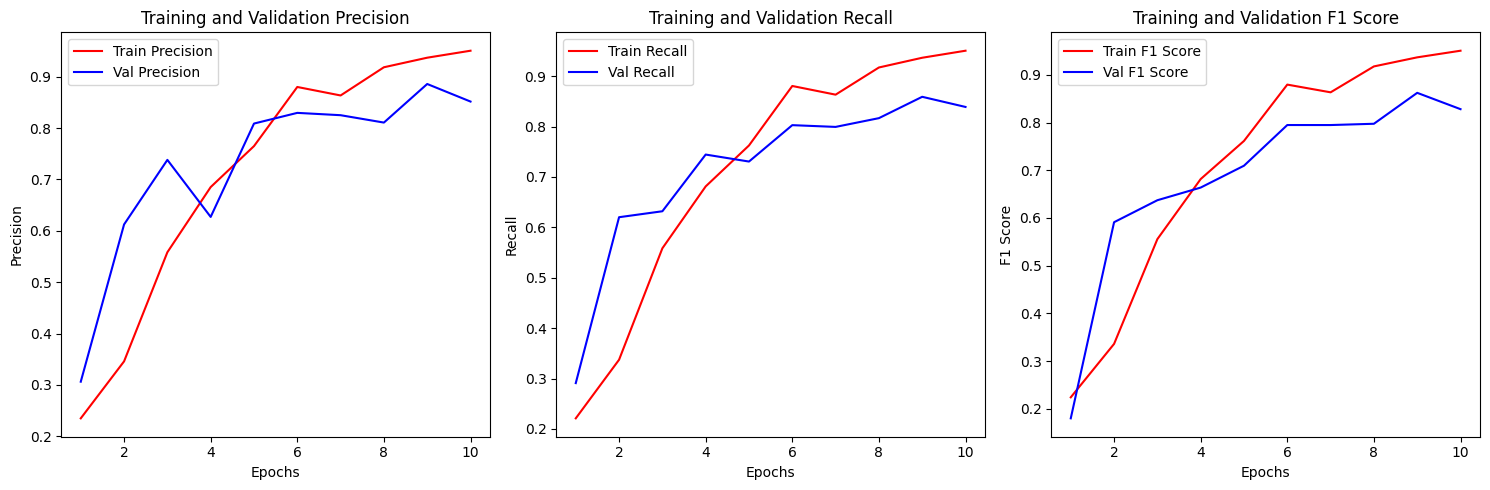

In [91]:
train_and_validate(model_dense, criterion, optimizer, train_loader, test_loader, n_epochs=10)

In [92]:
model_path = '/content/drive/MyDrive/CS445/Final Project/trained model/DC_DenseNet_model.pth'
torch.save(model_dense.state_dict(), model_path)

### Final Test

In [154]:
import os
from PIL import Image
from torch.utils.data import Dataset

class HandGestureTestDataset(Dataset):
    def __init__(self, rgb_dir, mask_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.label_mapping = {
            'like': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
        }
        self.samples = self._load_samples()

    # def _load_samples(self):
    #     samples = []

    #     # Iterate over all categories specified in the label mapping
    #     for category, label in self.label_mapping.items():
    #         rgb_path = os.path.join(self.rgb_dir, category)
    #         mask_path = os.path.join(self.mask_dir, category)

    #         # Ensure both directories exist
    #         if os.path.exists(rgb_path) and os.path.exists(mask_path):
    #             for filename in os.listdir(rgb_path):
    #                 if filename.endswith('.jpg'):
    #                     # Construct the corresponding mask filename
    #                     mask_filename = filename.replace('rgb', 'Predicted_Mask')
    #                     file_rgb_path = os.path.join(rgb_path, filename)
    #                     file_mask_path = os.path.join(mask_path, mask_filename)

    #                     # Check if the mask file exists before adding to samples
    #                     if os.path.exists(file_mask_path):
    #                         samples.append((file_rgb_path, file_mask_path, label))

    #     return samples
    def _load_samples(self):
        samples = []

        # Iterate over all categories specified in the label mapping
        for category, label in self.label_mapping.items():
            rgb_path = os.path.join(self.rgb_dir, category)
            mask_path = os.path.join(self.mask_dir, category)

            # Print to see if the directories exist
            print(f"Checking directories for category '{category}'")
            print(f"RGB directory: {rgb_path} (Exists: {os.path.exists(rgb_path)})")
            print(f"Mask directory: {mask_path} (Exists: {os.path.exists(mask_path)})")

            # Ensure both directories exist
            if os.path.exists(rgb_path) and os.path.exists(mask_path):
                for filename in os.listdir(rgb_path):
                    if filename.endswith('.jpg'):
                        # Construct the corresponding mask filename
                        mask_filename = filename.replace('rgb', 'Predicted_Mask')
                        file_rgb_path = os.path.join(rgb_path, filename)
                        file_mask_path = os.path.join(mask_path, mask_filename)

                        # Check if the mask file exists before adding to samples
                        if os.path.exists(file_mask_path):
                            samples.append((file_rgb_path, file_mask_path, label))
                        else:
                            print(f"Missing mask file: {file_mask_path}")
                    else:
                        print(f"Ignored non-JPG file: {filename}")

            else:
                print(f"Directory missing for category '{category}'")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgb_path, mask_path, label = self.samples[idx]
        rgb_image = Image.open(rgb_path).convert('RGB')
        mask_image = Image.open(mask_path).convert('L')  # Assuming masks are grayscale

        if self.transform:
            rgb_image = self.transform(rgb_image)
            mask_image = self.transform(mask_image)

        return rgb_image, mask_image, label


# Usage
rgb_dir = '/content/drive/MyDrive/CS445/Final Project/test_final/rgb'
mask_dir = '/content/drive/MyDrive/CS445/Final Project/test_final/mask'

final_dataset = HandGestureTestDataset(rgb_dir, mask_dir, transform=transform)


Checking directories for category 'like'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/like (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/like (Exists: True)
Checking directories for category '1'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/1 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/1 (Exists: True)
Checking directories for category '2'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/2 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/2 (Exists: True)
Checking directories for category '3'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/3 (Exists: True)
Mask directory: /content/drive/MyDrive/CS445/Final Project/test_final/mask/3 (Exists: True)
Checking directories for category '4'
RGB directory: /content/drive/MyDrive/CS445/Final Project/test_final/rgb/

In [155]:
final_test_loader = DataLoader(final_dataset, shuffle=False)

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine if GPU is available
model.to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

predictions = []
labels_list = []

# No gradient needed for evaluation
with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data  # Unpack the RGB images, masks, and labels

        # Move inputs and labels to the same device as the model
        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        # Pass both RGB and mask inputs to the model
        outputs = model(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        # Convert predictions and labels to the CPU for metric calculations
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
predictions = np.array(predictions)
labels_list = np.array(labels_list)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')

# Generate a confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.30
Recall: 0.25
F1-Score: 0.25
Confusion Matrix:
[[2 0 1 2 3 2]
 [1 1 2 1 2 3]
 [2 0 2 1 2 3]
 [0 1 1 3 3 2]
 [1 0 1 1 3 5]
 [0 0 2 4 0 5]]


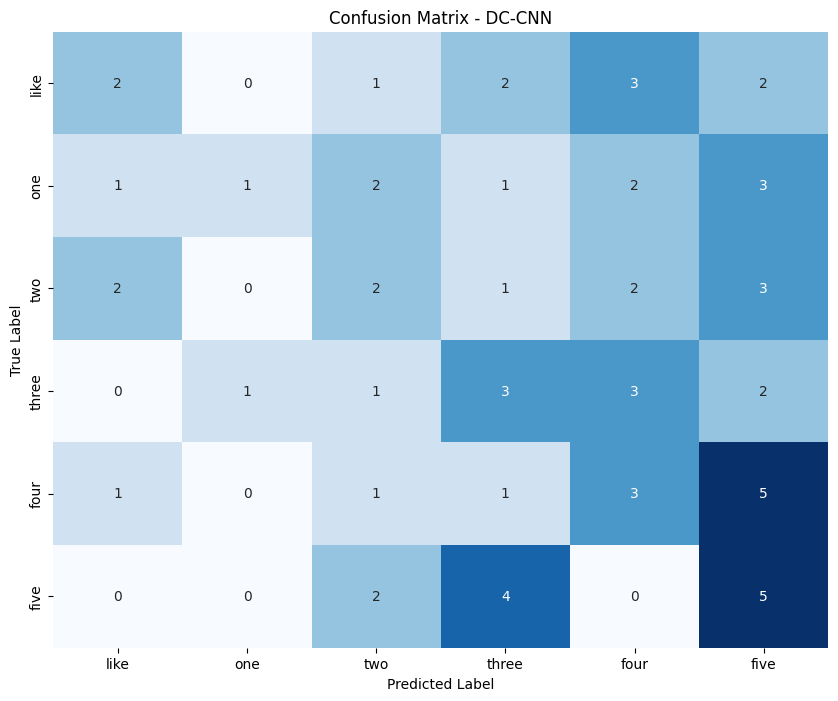

In [177]:
label_names = ['like', 'one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC-CNN")
plt.show()


ResNet

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine if GPU is available
model_res.to(device)  # Move the model to the appropriate device
model_res.eval()  # Set the model to evaluation mode

predictions = []
labels_list = []

# No gradient needed for evaluation
with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data  # Unpack the RGB images, masks, and labels

        # Move inputs and labels to the same device as the model
        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        # Pass both RGB and mask inputs to the model
        outputs = model_res(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        # Convert predictions and labels to the CPU for metric calculations
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
predictions = np.array(predictions)
labels_list = np.array(labels_list)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')

# Generate a confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.52
Recall: 0.30
F1-Score: 0.29
Confusion Matrix:
[[1 3 0 1 1 4]
 [0 7 0 0 1 2]
 [0 0 2 3 4 1]
 [0 0 0 0 8 2]
 [0 0 0 2 6 3]
 [0 0 0 0 8 3]]


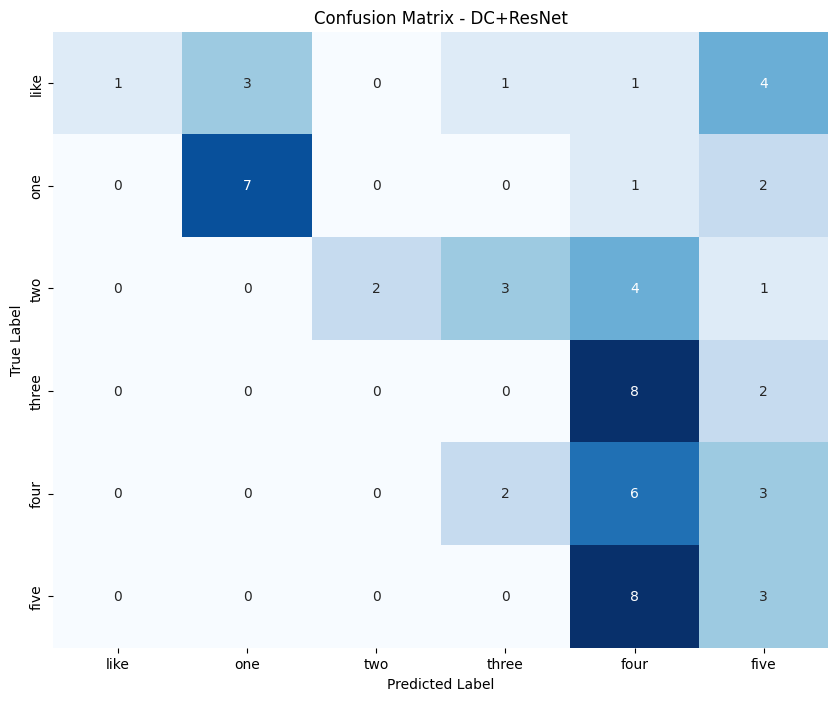

In [174]:
label_names = ['like', 'one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+ResNet")
plt.show()


VGG

In [179]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine if GPU is available
model_vgg.to(device)  # Move the model to the appropriate device
model_vgg.eval()  # Set the model to evaluation mode

predictions = []
labels_list = []

# No gradient needed for evaluation
with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data  # Unpack the RGB images, masks, and labels

        # Move inputs and labels to the same device as the model
        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        # Pass both RGB and mask inputs to the model
        outputs = model_vgg(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        # Convert predictions and labels to the CPU for metric calculations
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
predictions = np.array(predictions)
labels_list = np.array(labels_list)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')

# Generate a confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.32
Recall: 0.30
F1-Score: 0.28
Confusion Matrix:
[[1 1 2 1 3 2]
 [0 3 4 2 1 0]
 [3 0 1 4 1 1]
 [0 0 0 1 5 4]
 [0 0 0 0 6 5]
 [0 0 1 0 3 7]]


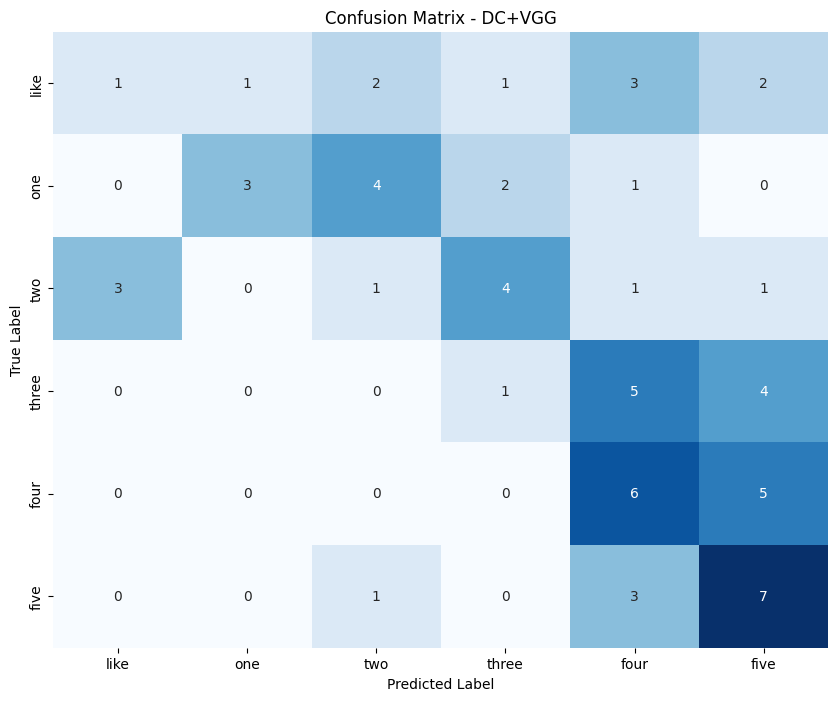

In [180]:
label_names = ['like', 'one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+VGG")
plt.show()


DenseNet

In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine if GPU is available
model_dense.to(device)  # Move the model to the appropriate device
model_dense.eval()  # Set the model to evaluation mode

predictions = []
labels_list = []

# No gradient needed for evaluation
with torch.no_grad():
    for data in final_test_loader:
        inputs_rgb, inputs_mask, labels = data  # Unpack the RGB images, masks, and labels

        # Move inputs and labels to the same device as the model
        inputs_rgb = inputs_rgb.to(device)
        inputs_mask = inputs_mask.to(device)
        labels = labels.to(device)

        # Pass both RGB and mask inputs to the model
        outputs = model_dense(inputs_rgb, inputs_mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes

        # Convert predictions and labels to the CPU for metric calculations
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
predictions = np.array(predictions)
labels_list = np.array(labels_list)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list, predictions, average='macro')
recall = recall_score(labels_list, predictions, average='macro')
f1 = f1_score(labels_list, predictions, average='macro')

# Generate a confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.33
Recall: 0.43
F1-Score: 0.36
Confusion Matrix:
[[ 0  4  1  3  1  1]
 [ 0  8  2  0  0  0]
 [ 0  2  2  4  2  0]
 [ 0  0  0  1  6  3]
 [ 0  0  0  0  6  5]
 [ 0  0  0  0  1 10]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


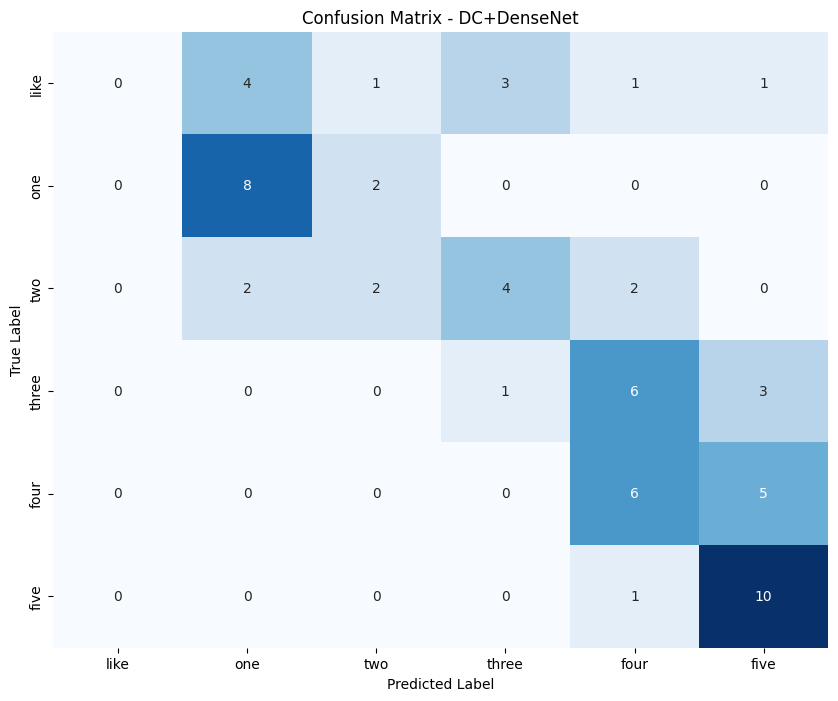

In [182]:
label_names = ['like', 'one', 'two', 'three', 'four', 'five']

# Convert the names to the corresponding numeric labels for the confusion matrix
numeric_labels = [0, 1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(labels_list, predictions, labels=numeric_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DC+DenseNet")
plt.show()
